In [1]:
%%html
<style>
table {align:left;display:block}
</style>

## <font color='blue'>NTUC Capstone Project - Stroke Prediction using Machine Learning</font>

#### Source of Dataset : https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

##### Dataset Information
|Attribute|Description|
|:--:|:--|
|id|unique identifier|
|gender|"Male", "Female" or "Other"|
|age|age of the patient|
|hypertension|0 if the patient doesn't have hypertension, 1 if the patient has hypertension|
|heart_disease|0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease|
|ever_married|"No" or "Yes"|
|work_type|"children", "Govt_jov", "Never_worked", "Private" or "Self-employed"|
|Residence_type|"Rural" or "Urban"|
|avg_glucose_level|average glucose level in blood|
|bmi|body mass index|
|smoking_status|"formerly smoked", "never smoked", "smokes" or "Unknown"* |
|stroke|1 if the patient had a stroke or 0 if not|

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

Credits to fedesoriano [ https://www.kaggle.com/fedesoriano ]

# Import libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Define Functions

### Function to Print Test Results

In [3]:
# Display method results
def print_result(y_test, y_pred):
    
    # Print accurary score
    accuracy=accuracy_score(y_test,y_pred)
    print("Accuracy is :", accuracy)
    
    # Print classification report results
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)
    
    #Confusion Matrix 
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(7,3))

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues");
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix');
    plt.show()


### Function to Identify Outliers in Dataset using IQR (Interquartile Range)

Interquartile Range, IQR is a property that is used to measure variability. The IQR divides a dataset into quartiles. These quartiles store data after the data gets sorted in ascending order and split into 4 equal parts. The first, second, and third quartiles are called Q1, Q2, and Q3. These quartiles are the values that separate the 4 equal parts.

The following is the percentile distribution of the data amongst Q1, Q2, and Q3.

* 25th percentile of the data is represented in Q1
* 50th percentile of the data is represented in Q2
* 75th percentile of data is represented in Q3

The measurement of IQR gives an insight into the width of distribution as most of the points of the dataset are contained in this range.

In a dataset that contains even or odd elements of data points, then-

* Q1 is the median
* Q2 is the median of x smallest points of data
* Q3 is the median of x highest points of data

In Machine Learning, the best use of the Interquartile Range is to measure the variability of the distribution of data that contains outliers. IQR does not get affected by outliers. Hence, it is ideal to use IQR to detect the outliers for it is a value that lies in the middle of a dataset distribution.

The upper fence is the boundary around the third quartile. It tells you that any values exceeding the upper fence are outliers.

The lower fence is the boundary around the first quartile. Any values less than the lower fence are outliers.

The number (here 1.5, which is the scale) clearly controls the sensitivity of the range and hence the decision rule. A bigger scale would make the outlier(s) to be considered as data point(s) while a smaller one would make some of the data point(s) to be perceived as outlier(s).


<img align='left' src="images/IQR.jpg" style="width: 600px;"/>

In [4]:
# Function to identify outliers
def detect_outliers(data,column, display=False):
    
    # Identify the first quartile (Q1)
    q1 = data[column].quantile(.25)
    
    # Identify third quartile (Q3)
    q3= data[column].quantile(.75)
    
    # Calculate your IQR = Q3 – Q1
    IQR = q3-q1

    # Calculate your lower fence = Q1 – (1.5 * IQR)
    lower_bound = q1 - (1.5*IQR)
    
    # Calculate your upper fence = Q3 + (1.5 * IQR)
    upper_bound = q3 + (1.5*IQR)
    
    if display:
        print(f'Column:{column}, Upper:{upper_bound}, Lower:{lower_bound}, Q1:{q1}, Q3:{q3}, IQR:{IQR}')

    # Use your fences to highlight any outliers, all values that fall outside your fences.
    ls = data.index[(data[column] < lower_bound) | (data[column] > upper_bound)]

    return ls

In [5]:
# Display Outliers
def display_outliers(data, column):
    index_list = []
    index_list.extend(detect_outliers(data,column,display=True))
    if len(index_list) > 0:
        index_list = sorted(set(index_list))
        print(f'Total Outliers: {len(data.iloc[index_list])}')
        display(data.iloc[index_list].groupby(['stroke'])[column].count())
        display(data.iloc[index_list].describe())

### Function to Remove Outliers from Dataset

In [6]:
# Function to remove outliers from dataset
def remove_outliers(data, cols):
    index_list = []

    for column in cols:
        index_list.extend(detect_outliers(data,column))

    # remove duplicated indices in the index_list and sort it 
    index_list = sorted(set(index_list))

    before_remove = data.shape
    data = data.drop(index_list)
    after_remove = data.shape

    print()
    print(f'Shape of data before removing outliers : {before_remove}')
    print(f'Shape of data after remove : {after_remove}')
    print(f'Total records removed: {len(index_list)}')
    
    return data

### Function to display countplot

In [7]:
def print_countplot(data, column, hue=True, legend=True):
    print("")
    print('Unique values : ',data[column].unique())
    print('Value Counts  :')
    print(data[column].value_counts())
    
    if hue:
        ax = sns.countplot(data=data,x=column,hue='stroke')
    else:
        ax = sns.countplot(data=data,x=column)
    for label in ax.containers:
        ax.bar_label(label)
    plt.title("Distribution of " + column.capitalize())
    if legend:
        plt.legend(
            labels = ['No','Yes'],
            title = 'Stroke')
    plt.show()

### Function to display histogram & boxplot

In [8]:
def print_hist_box(data, column):
    print("")
    print('No. of unique values: ', data[column].nunique())
    print("Min value: ", data[column].min())
    print("Max value: ", data[column].max())
    print("")
    
    fig1, ax = plt.subplots(1,2, figsize=(10,5)) # 1 row, 2 columns
    
    # histogram
    sns.histplot(data=data, x=column, hue='stroke', ax=ax[0])
    ax[0].legend(labels = ['Yes','No'], title = 'Stroke')
    
    # boxplot
    sns.boxplot(data=data,x='stroke',y=column, ax=ax[1])    
    plt.xticks(ticks=[1,0], labels=["Yes", "No"]);

### Function to display heatmap

In [9]:
def print_heatmap(data, dropId=True):
    plt.figure(figsize=(15,10))
    if dropId:
        sns.heatmap(data.drop(columns='id').corr(numeric_only=True),annot=True,fmt='.2')
    else:
        sns.heatmap(data.corr(numeric_only=True),annot=True,fmt='.2')
    plt.show()

## Read Dataset

In [10]:
# read dataset files
stroke_df = pd.read_csv("healthcare-dataset-stroke-data.csv")
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Exploration

There are total 5110 records in the dataset, consisting of 7 numeric columns and 5 object columns.

Of the 7 numeric columns, "hypertension", "heart_disease" and "stroke" columns are of binary values, while "age", "avg_glucose_level" and "bmi" columns are of continuous data. "id" column is the unique key representing the dataset records.

The 5 object columns are categorical data, "ever_married" & "Residence_type" columns have values that can be treated as binary, while the rest are nominal data.

"stroke" column is the target/outcome variable, while the other columns (excluding "id") which will form the features of our models.

"bmi" column contains null data.

In [11]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [12]:
# find which fields are non-numeric
numerical_var = []
categorical_var = []

#for column in stroke_df.drop(columns='stroke').columns:
for column in stroke_df.columns:
    if not np.issubdtype(stroke_df[column].dtype, np.number):
        categorical_var.append(column)
        print(f"{column} : dtype=[{stroke_df[column].dtype}], values={stroke_df[column].unique()}")
    else:
        numerical_var.append(column)
        if stroke_df[column].unique().size <= 2:
            print(f"{column} : dtype=[{stroke_df[column].dtype}], values={stroke_df[column].unique()}")

print("")
print(f'Categorical variable: {categorical_var}')
print(f'Numerical variable  : {numerical_var}')

gender : dtype=[object], values=['Male' 'Female' 'Other']
hypertension : dtype=[int64], values=[0 1]
heart_disease : dtype=[int64], values=[1 0]
ever_married : dtype=[object], values=['Yes' 'No']
work_type : dtype=[object], values=['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type : dtype=[object], values=['Urban' 'Rural']
smoking_status : dtype=[object], values=['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke : dtype=[int64], values=[1 0]

Categorical variable: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Numerical variable  : ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']


### Distribution of Dataset Columns

### Stroke

This is the target/outcome variable of the dataset, whereby it shows whether the person has stroke / no stroke.

From the graph, it can seen that there is an imbalance in the dataset whereby number of cases that represent having stroke or no stroke outcome. 


Unique values :  [1 0]
Value Counts  :
0    4861
1     249
Name: stroke, dtype: int64


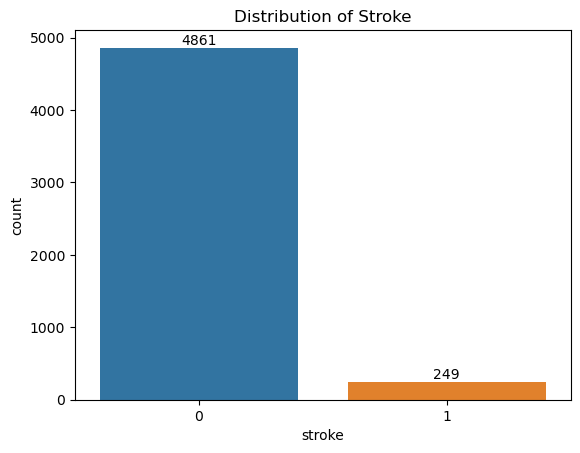

In [13]:
# stroke (dependent / target variable)
print_countplot(data=stroke_df, column='stroke', hue=False, legend=False)

### Gender

Dataset seems to have more records of gender 'Female'. Although the number of cases with Stroke outcome is higher in the gender 'Female', but the percent of stroke in gender 'Female' is 4.9% which is slightly lower compare to percent of stroke in gender 'Male' which is 5.4%.

There is also a record of gender 'Other'.


Unique values :  ['Male' 'Female' 'Other']
Value Counts  :
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


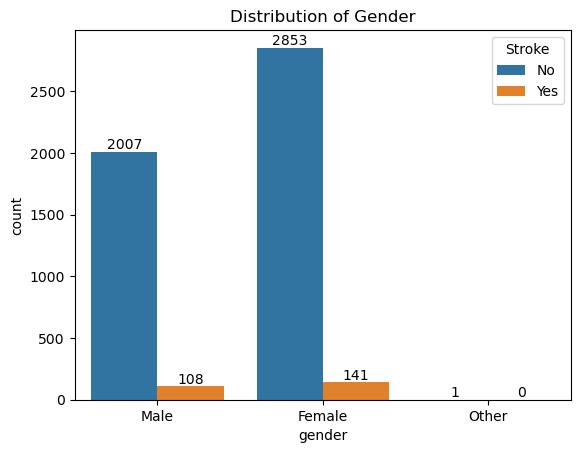

In [14]:
# Gender
print_countplot(stroke_df, 'gender')

### Hypertension

The number of cases with hypertension is much lesser than those with no hypertension.

Although the number of cases with stroke outcome seems lower than those with no hypertension, the percentage of possibly having stroke is 15% in those with hypertension as compare to 4% in those with no hypertension. So on the whole, there is still an higher risk of having stroke if the person has hypertension.


Unique values :  [0 1]
Value Counts  :
0    4612
1     498
Name: hypertension, dtype: int64


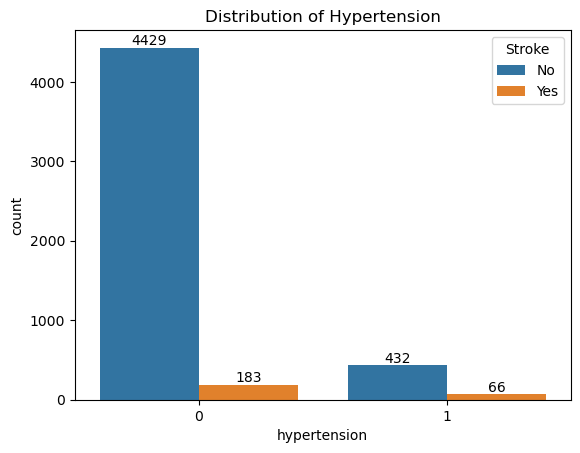

In [15]:
# hypertension
print_countplot(stroke_df, 'hypertension')

### Heart Disease

The number of cases with heart disease is much lesser than those with no heart disease.

Although the number of cases with stroke outcome seems lower than those with no heart disease, the percentage of possibly having stroke is 20% in those with heart disease as compare to 4% in those with no hypertension. So on the whole, there is still an higher risk of having stroke if the person has heart disease.


Unique values :  [1 0]
Value Counts  :
0    4834
1     276
Name: heart_disease, dtype: int64


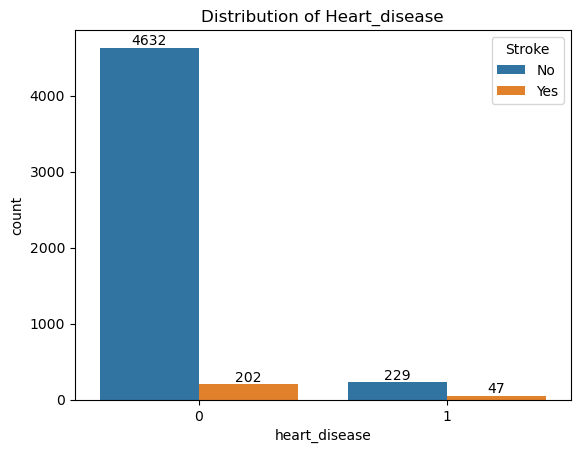

In [16]:
# heart_disease
print_countplot(stroke_df, 'heart_disease')

### Ever Married

The number of ever married cases is much lesser than those with not ever married.

Although the number of cases with stroke outcome seems lower than those with not ever married, the percentage of possibly having stroke is 7% in those ever married as compare to 1.6% in those with not ever married. So on the whole, there is still an higher risk of having stroke if the person has ever married.


Unique values :  ['Yes' 'No']
Value Counts  :
Yes    3353
No     1757
Name: ever_married, dtype: int64


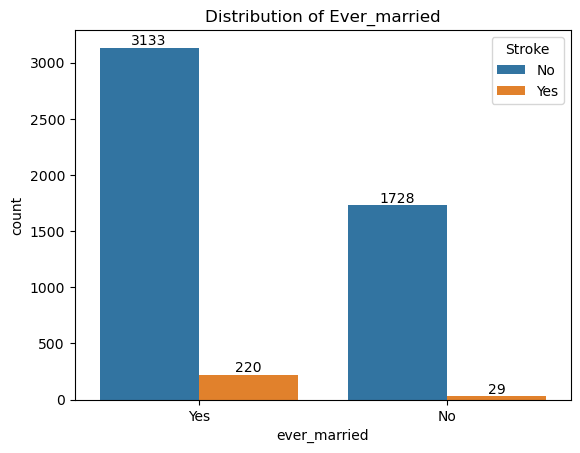

In [17]:
# ever_married
print_countplot(stroke_df, 'ever_married')

### Work Type

Majority of the cases work in Private sector, while the rest are spread out amongst Self-employed, Govt Job, or are children, with the least cases in not working.

Those whom are Self-employed has an 8% risk of having stroke, which is higher than the rest which is 5% and below.


Unique values :  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Value Counts  :
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


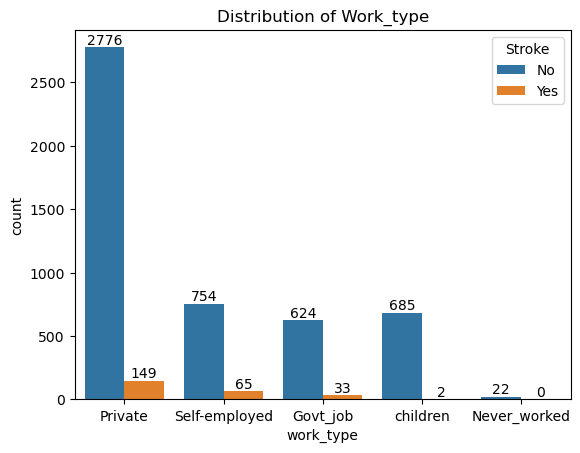

In [18]:
# work_type
print_countplot(stroke_df, 'work_type')

### Residence Type

Cases are relatively even between Urban and Rural residence area, as well for the stroke outcome.


Unique values :  ['Urban' 'Rural']
Value Counts  :
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


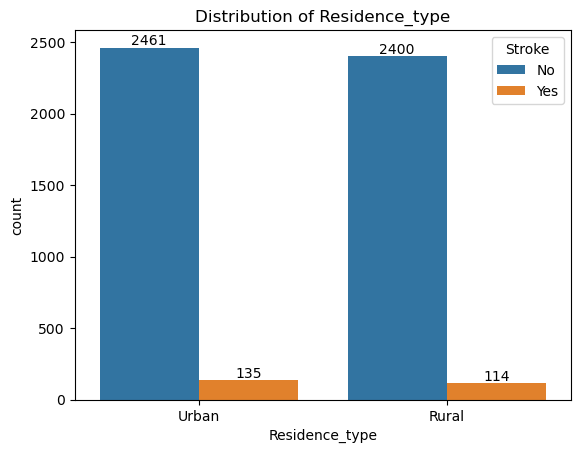

In [19]:
# Residence_type
print_countplot(stroke_df, 'Residence_type')

### Smoking Status

The number of cases having stroke is more or less spread out amongst the different smoking status but those that formally smoked has an 8.5% risk.


Unique values :  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
Value Counts  :
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


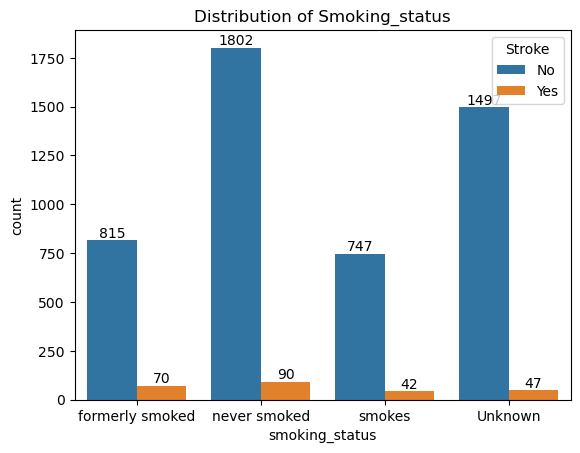

In [20]:
# smoking_status
print_countplot(data=stroke_df, column='smoking_status')

### Age

Stroke seems to have higher occurrence for those age around 60 and above.

According to boxplot, there is no outliers under the 'No Stroke' outcome, but there are two outliers (age below 20) under the 'Stroke' outcome.

Even though stroke is not common amongst children, but it may still happen. And since there is only two outliers record, we shall retain these two records instead.


No. of unique values:  104
Min value:  0.08
Max value:  82.0



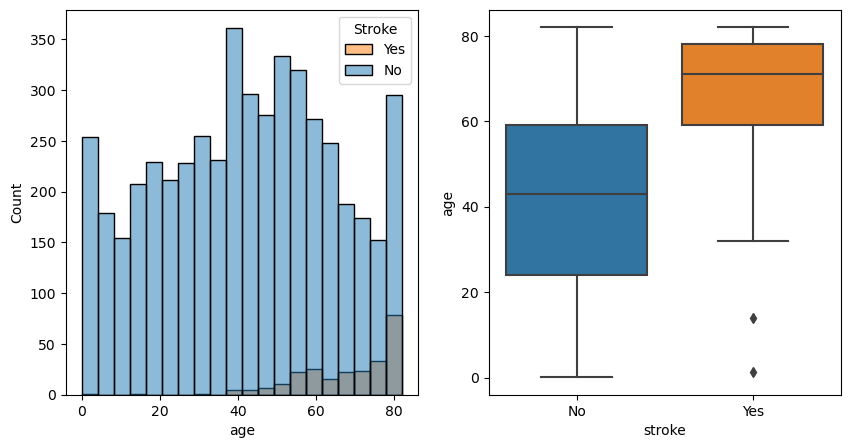

In [21]:
# Age
print_hist_box(stroke_df, 'age')

In [22]:
display(stroke_df[stroke_df['age'] < 20].groupby(['stroke'])['stroke'].count())
display(stroke_df[(stroke_df['age'] < 20) & (stroke_df['stroke'] == 1)])

stroke
0    964
1      2
Name: stroke, dtype: int64

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1


### BMI  (Body Mass Index)

Cases having stroke or no stroke outcome are more or less within the same range of BMI values.

There seemed to be more outliers at the upper boundary of Not Stroke outcome as compare to Stroke outcome.

<img align='left' src="images/BMI.jpg" style="width: 600px;"/>


No. of unique values:  418
Min value:  10.3
Max value:  97.6



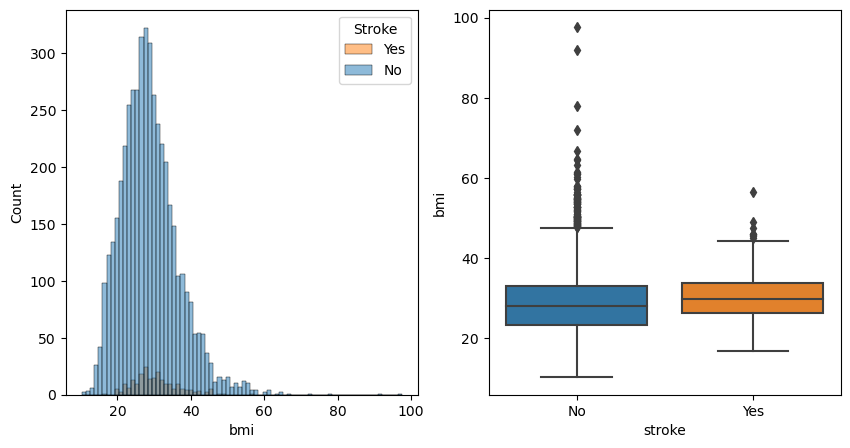

In [23]:
# bmi
col = 'bmi'
print_hist_box(stroke_df, col)

In [24]:
display_outliers(stroke_df, col)

display(stroke_df[(stroke_df[col] > 40)].describe())

Column:bmi, Upper:47.5, Lower:9.099999999999998, Q1:23.5, Q3:33.1, IQR:9.600000000000001
Total Outliers: 110


stroke
0    108
1      2
Name: bmi, dtype: int64

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,32491.300000,44.463636,0.190909,0.009091,119.972364,54.181818,0.018182
std,22189.333253,13.210836,0.394816,0.095346,57.169152,7.565302,0.134220
min,99.000000,14.000000,0.000000,0.000000,56.630000,47.600000,0.000000
25%,12024.250000,35.500000,0.000000,0.000000,79.225000,49.800000,0.000000
50%,32311.000000,46.000000,0.000000,0.000000,96.050000,52.750000,0.000000
75%,50035.000000,53.000000,0.000000,0.000000,169.575000,55.700000,0.000000
max,72911.000000,74.000000,1.000000,1.000000,239.190000,97.600000,1.000000


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000
mean,37119.585784,46.098039,0.169118,0.029412,122.362402,45.889951,0.044118
std,21049.898553,15.072803,0.375316,0.169165,57.858490,6.595000,0.205609
min,99.000000,13.000000,0.000000,0.000000,55.640000,40.100000,0.000000
25%,19677.250000,35.000000,0.000000,0.000000,79.352500,41.700000,0.000000
50%,37667.500000,46.500000,0.000000,0.000000,97.270000,43.800000,0.000000
75%,54359.250000,56.000000,0.000000,0.000000,176.000000,48.125000,0.000000
max,72915.000000,82.000000,1.000000,1.000000,261.670000,97.600000,1.000000


### Average Glucose Level

Assuming using the fasting glucose level.

<img align='left' src="images/glucose.jpg" style="width: 400px;"/>
<br clear="left"/>

Hypoglycemia : below 70 mg/dL (3.9 mmol/L)


No. of unique values:  3979
Min value:  55.12
Max value:  271.74



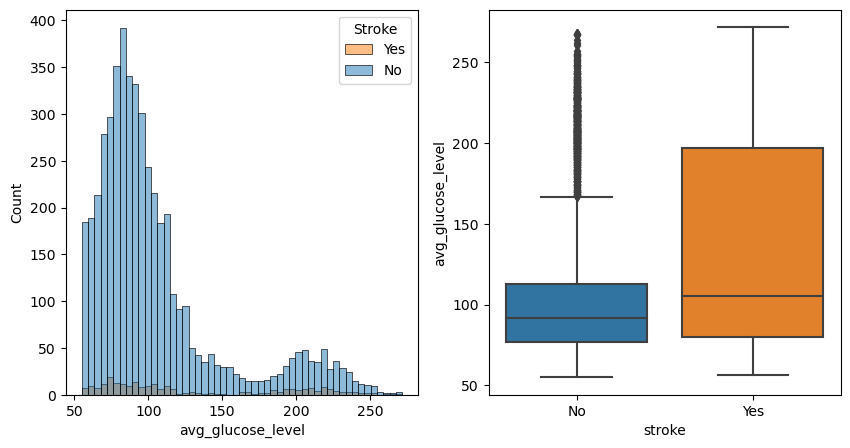

In [25]:
# avg_glucose_level
col = 'avg_glucose_level'
print_hist_box(stroke_df, col)

In [26]:
display_outliers(stroke_df, col)

display(stroke_df[stroke_df[col]>200].describe())

Column:avg_glucose_level, Upper:169.35750000000002, Lower:21.977500000000006, Q1:77.245, Q3:114.09, IQR:36.845
Total Outliers: 627


stroke
0    543
1     84
Name: avg_glucose_level, dtype: int64

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,627.000000,627.000000,627.000000,627.000000,627.000000,566.000000,627.000000
mean,36040.728868,59.959553,0.258373,0.164274,211.341595,33.353180,0.133971
std,21013.145967,16.257800,0.438090,0.370820,20.825706,7.930821,0.340893
min,239.000000,1.000000,0.000000,0.000000,169.430000,14.200000,0.000000
25%,16920.000000,52.000000,0.000000,0.000000,196.760000,27.700000,0.000000
50%,36377.000000,62.000000,0.000000,0.000000,210.000000,32.100000,0.000000
75%,53477.500000,72.500000,1.000000,0.000000,226.715000,37.575000,0.000000
max,72915.000000,82.000000,1.000000,1.000000,271.740000,71.900000,1.000000


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,434.000000,434.000000,434.000000,434.000000,434.000000,391.000000,434.000000
mean,35036.758065,61.629032,0.241935,0.168203,221.791267,33.950384,0.129032
std,20761.080606,14.995401,0.428750,0.374478,15.357093,8.031326,0.335623
min,239.000000,4.000000,0.000000,0.000000,200.140000,14.200000,0.000000
25%,16954.500000,53.000000,0.000000,0.000000,208.797500,28.150000,0.000000
50%,35178.500000,63.000000,0.000000,0.000000,219.600000,32.800000,0.000000
75%,52140.000000,74.000000,0.000000,0.000000,231.555000,38.600000,0.000000
max,72819.000000,82.000000,1.000000,1.000000,271.740000,71.900000,1.000000


## Data Processing

### Check for null values in dataset

In [27]:
# Check for null values in dataset

stroke_df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Handling null values in BMI column

There are total 201 records with null values, with 161 records belong to non-stroke output and 40 to stroke output.

In [28]:
# need to populate some values for the BMI null values

print("Breakdown count of null values in BMI according to stroke outcome:")
print(stroke_df[stroke_df['bmi'].isna()].groupby(['stroke'])['stroke'].count())

# compare mean values of BMI with stroke vs non-stroke
print("\nMean values of BMI:")
print('Non-stroke:',stroke_df[stroke_df['stroke']==0]['bmi'].mean())
print('Stroke    :',stroke_df[stroke_df['stroke']==1]['bmi'].mean())
print('Overall   :',stroke_df['bmi'].mean())

# compare median values of BMI with stroke vs non-stroke
print("\nMedian values of BMI:")
print('Non-stroke:',stroke_df[stroke_df['stroke']==0]['bmi'].median())
print('Stroke    :',stroke_df[stroke_df['stroke']==1]['bmi'].median())
print('Overall   :',stroke_df['bmi'].median())

Breakdown count of null values in BMI according to stroke outcome:
stroke
0    161
1     40
Name: stroke, dtype: int64

Mean values of BMI:
Non-stroke: 28.823063829787234
Stroke    : 30.471291866028707
Overall   : 28.893236911794666

Median values of BMI:
Non-stroke: 28.0
Stroke    : 29.7
Overall   : 28.1


### Use mean value of BMI to populate null in the column

As there little difference between mean and median of BMI in the dataset, mean value of BMI will be used to populate null values in the BMI column.

Another way is to remove the null records, but as the dataset is not huge, it is better to retain these records.

In [29]:
# fill those BMI of null values with mean value as little difference between mean or median for both output
stroke_df['bmi'].fillna(stroke_df['bmi'].mean(), inplace=True)

# check that no more null values in dataset
display(stroke_df.isnull().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Remove ID column from dataset

In [30]:
# ID is the key for the data and does not affect result in anyway, therefore removed from dataset 
stroke_df.drop('id',axis=1,inplace=True)

In [31]:
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


### Check and Remove Duplicates from Dataset if any

In [32]:
display(stroke_df[stroke_df.duplicated()])

# Remove duplicates if any
stroke_df.drop_duplicates(inplace=True)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


### Remove "Other" gender record from Dataset

There is only 1 gender record of "Other" value, therefore remove record.

In [33]:
display(stroke_df['gender'].value_counts())
display(stroke_df[stroke_df['gender'] == 'Other'])

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [34]:
stroke_df.drop(stroke_df[stroke_df['gender'] == 'Other'].index, inplace = True)
stroke_df['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

### Removing Outliers

First round of model training and testing to leave outliers intact.

Second round to remove outliers to see the effects on the models.

In [35]:
# stroke_df = remove_outliers(stroke_df, ['avg_glucose_level', 'bmi'])

In [36]:
stroke_df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


### Convert Categorical Data to Numeric Data

As the columns "Residence_type", "ever_married" contains only 2 values each, values will be converted into 0 & 1 respectively.

Perform one-hot encoding on 'smoking_status' and 'work_type' which will convert the values of these two feature into individual columns with value of 0 or 1.

In [37]:
def convert_cat_2_num(data):
    new_data = data.copy()

    # Replacing the values
    new_data["Residence_type"] = new_data["Residence_type"].apply(lambda x: 1 if x=="Urban" else 0)
    new_data["ever_married"] = new_data["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)
    new_data["gender"] = new_data["gender"].apply(lambda x: 1 if x=="Male" else 0)

    # perform one-hot encoding
    new_data = pd.get_dummies(data=new_data, columns=['smoking_status'])
    new_data = pd.get_dummies(data=new_data, columns=['work_type'])

    # move stroke column to end of dataframe
    new_cols = [col for col in new_data.columns if col != 'stroke'] + ['stroke']
    return new_data[new_cols]

stroke_df = convert_cat_2_num(stroke_df)

In [38]:
stroke_df

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,stroke
0,1,67.0,0,1,1,1,228.69,36.600000,0,1,0,0,0,0,1,0,0,1
1,0,61.0,0,0,1,0,202.21,28.893237,0,0,1,0,0,0,0,1,0,1
2,1,80.0,0,1,1,0,105.92,32.500000,0,0,1,0,0,0,1,0,0,1
3,0,49.0,0,0,1,1,171.23,34.400000,0,0,0,1,0,0,1,0,0,1
4,0,79.0,1,0,1,0,174.12,24.000000,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,1,83.75,28.893237,0,0,1,0,0,0,1,0,0,0
5106,0,81.0,0,0,1,1,125.20,40.000000,0,0,1,0,0,0,0,1,0,0
5107,0,35.0,0,0,1,0,82.99,30.600000,0,0,1,0,0,0,0,1,0,0
5108,1,51.0,0,0,1,0,166.29,25.600000,0,1,0,0,0,0,1,0,0,0


### Features Correlation

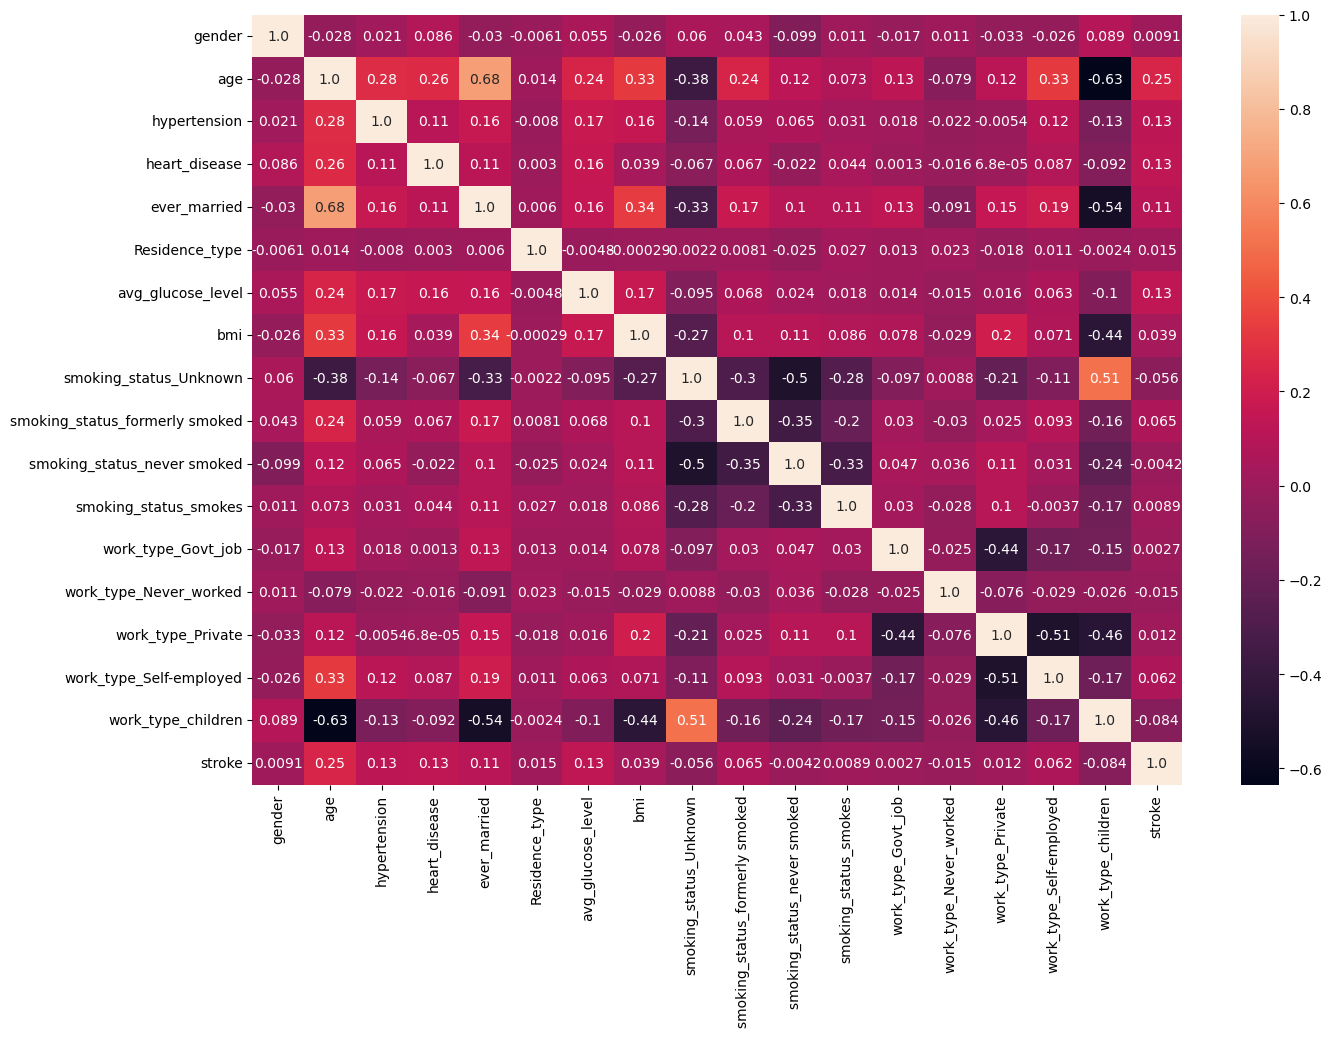

In [39]:
# print correlation heatmap of the features
print_heatmap(stroke_df, dropId=False)

In [40]:
# sort and display top 10 features most correlated with target variable
corr_matrix = stroke_df.corr()['stroke'].drop(index='stroke').sort_values(ascending=False)
print("\nTop 10 correlated columns to stroke output:")
display(corr_matrix.head(10))


Top 10 correlated columns to stroke output:


age                               0.245239
heart_disease                     0.134905
avg_glucose_level                 0.131991
hypertension                      0.127891
ever_married                      0.108299
smoking_status_formerly smoked    0.064683
work_type_Self-employed           0.062150
bmi                               0.038912
Residence_type                    0.015415
work_type_Private                 0.011927
Name: stroke, dtype: float64

## Split into features and output dataset

In [41]:
X=stroke_df.drop('stroke',axis=1)
X.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,1,67.0,0,1,1,1,228.69,36.600000,0,1,0,0,0,0,1,0,0
1,0,61.0,0,0,1,0,202.21,28.893237,0,0,1,0,0,0,0,1,0
2,1,80.0,0,1,1,0,105.92,32.500000,0,0,1,0,0,0,1,0,0
3,0,49.0,0,0,1,1,171.23,34.400000,0,0,0,1,0,0,1,0,0
4,0,79.0,1,0,1,0,174.12,24.000000,0,0,1,0,0,0,0,1,0


In [42]:
Y=stroke_df['stroke']
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: stroke, dtype: int64

In [43]:
Y.value_counts()

0    4860
1     249
Name: stroke, dtype: int64

### <font color='grey'> Try SMOTE on dataset before split into Training & Testing

<font color='grey'>Note that SMOTE() is apply here before the train & test split is only for result comparison purposes only.</font>

<font color='grey'>If SMOTE() is required to oversample the imbalance dataset, best practice, only to apply SMOTE() to the training dataset only.</font>

In [44]:
# smote = SMOTE(random_state=0)
# X, Y = smote.fit_resample(X, Y)

In [45]:
# display(Y.value_counts())

In [46]:
# display(X)

## Split dataset into Training & Testing data

Split the data randomly into training and test data. The training data is used to fit the model. The algorithm uses the training data to learn the relationship between the features and the target. The test data is used to evaluate the performance of the model.

In [47]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.25,random_state=0, stratify=Y)

In [48]:
# Training Set
for i in range(0,2):
    print(i, ":", Y_train[Y_train==i].size)

0 : 3644
1 : 187


In [49]:
# Testing Set
for i in range(0,2):
    print(i, ":", Y_test[Y_test==i].size)

0 : 1216
1 : 62


## Applying SMOTE to Imbalance Dataset

SMOTE (Synthetic Minority Oversampling Technique) is an oversampling method of balancing class distribution in the dataset. It selects the minority examples that are close to the feature space. Then, it draws the line between the examples in the features space and draws a new sample at a point along that line. 

In simple words, the algorithm selects the random example from the minority class and selects a random neighbor using K Nearest Neighbors. The synthetic example is created between two examples in the feature space. 

There is a drawback to using SMOTE, as it does not consider the majority class while creating synthetic examples. This can cause issues where there is a strong overlap between the classes.

In [50]:
sm = SMOTE(random_state=0)
X_train_resample, Y_train_resample = sm.fit_resample(X_train, Y_train)
#X_test, Y_test = sm.fit_resample(X_test, Y_test)

In [51]:
for i in range(0,2):
    print(i, ":", Y_train_resample[Y_train_resample==i].size)

for i in range(0,2):
    print(i, ":", Y_test[Y_test==i].size)

0 : 3644
1 : 3644
0 : 1216
1 : 62


### Confusion Matrix
<img align='left' src="images/confusion_matrix.jpg" style="width: 400px;"/>
<br clear="left"/>

* True Negative (Top-Left Quadrant)
* False Positive (Top-Right Quadrant)
* False Negative (Bottom-Left Quadrant)
* True Positive (Bottom-Right Quadrant)

#### Accuracy
Accuracy measures how often the model is correct.

        Accuracy = (True Positive + True Negative) / Total Predictions

#### Precision
Of the positives predicted, what percentage is truly positive? Precision does not evaluate the correctly predicted negative cases.

        Precision = True Positive / (True Positive + False Positive)

#### Sensitivity (Recall)
Of all the positive cases, what percentage are predicted positive?

Sensitivity (sometimes called Recall) measures how good the model is at predicting positives.

This means it looks at true positives and false negatives (which are positives that have been incorrectly predicted as negative).

        Recall = True Positive / (True Positive + False Negative)

Sensitivity is good at understanding how well the model predicts something is positive:

#### F-score
F-score is the "harmonic mean" of precision and sensitivity.

It considers both false positive and false negative cases and is good for imbalanced datasets.

        F-Score = 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))

This score does not take into consideration the True Negative values

# Logistic Regression

Logistic regression is a statistical method used to model the relationship between a binary dependent variable and one or more independent variables. The goal of logistic regression is to predict the probability of an event occurring based on a set of predictor variables.

In logistic regression, the dependent variable is binary, meaning it can only take on two values, typically labeled as 0 or 1. The independent variables can be either continuous or categorical.

The logistic regression model is based on the logistic function, which is a type of S-shaped curve (sigmoid function) that maps any continuous input to a probability value between 0 and 1. The logistic function allows us to model the relationship between the independent variables and the probability of the dependent variable taking on the value of 1.

Logistic regression is easier to implement, interpret, and very efficient to train. It can be trained quickly, even on large datasets, and can handle a high number of features.


It can handle both categorical and continuous variables as input features and can be extended to model more complex relationships such as interactions between variables


It can be sensitive to outliers, which can affect the coefficients and predictions.

Logistic regression can be prone to overfitting if the number of independent variables is too large relative to the sample size.

Logistic regression is only suitable for analyzing binary outcomes and may not be appropriate for other types of outcomes.

In [52]:
# Train the LR model
def train_LR_model(X_train, Y_train):
    lr_model = LogisticRegression()
    lr_model.fit(X_train,Y_train)
    return lr_model

lr_model = train_LR_model(X_train_resample,Y_train_resample)
#lr_model = train_LR_model(X_train,Y_train)

Accuracy is : 0.903755868544601

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1216
           1       0.16      0.23      0.19        62

    accuracy                           0.90      1278
   macro avg       0.56      0.58      0.57      1278
weighted avg       0.92      0.90      0.91      1278



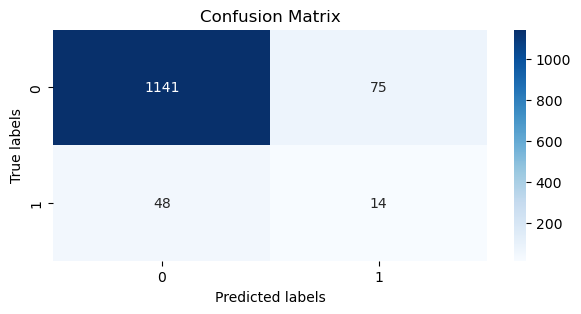

In [53]:
# define an function to use for testing the model
def run_model_test(model, X_test, Y_test):
    #testing model 
    y_pred = model.predict(X_test)

    # print result
    print_result(Y_test,y_pred)

run_model_test(lr_model, X_test, Y_test)

# XGBoost

XGBoost (Extreme Gradient Boosting) works by building an ensemble of decision trees, where each tree is trained to make predictions based on a subset of the available data. The trees are grown sequentially, with each tree learning from the mistakes of the previous tree. The final prediction is made by taking the average of the predictions from all of the trees in the ensemble.

One of the key advantages of XGBoost is its ability to handle missing data and large datasets efficiently. It also has a number of hyperparameters that can be tuned to improve model performance, including the learning rate, depth of the trees, and regularization parameters.

Effective with large data sets. Tree algorithms such as XGBoost and Random Forest do not need normalized features and work well if the data is nonlinear, non-monotonic, or with segregated clusters.

Tree algorithms such as XGBoost and Random Forest can over-fit the data, especially if the trees are too deep with noisy data.

In [54]:
# Train the XGB Model
def train_XGB_model(X_train, Y_train):
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, Y_train)
    return xgb_model
    
xgb_model = train_XGB_model(X_train_resample, Y_train_resample)
#xgb_model = train_XGB_model(X_train, Y_train)

Accuracy is : 0.9311424100156495

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1216
           1       0.14      0.08      0.10        62

    accuracy                           0.93      1278
   macro avg       0.55      0.53      0.53      1278
weighted avg       0.91      0.93      0.92      1278



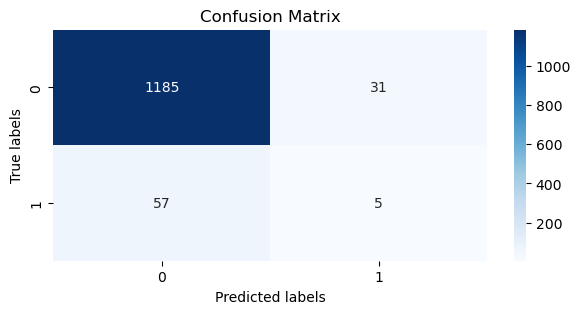

In [55]:
# running test dataset against the trained model
run_model_test(xgb_model, X_test, Y_test)

### Testing with SMOTE applied to testing set

* With outliers intact

* SMOTE to be done on testing set as well

In [56]:
X_test_resample, Y_test_resample = sm.fit_resample(X_test, Y_test)

In [57]:
for i in range(0,2):
    print(i, ":", Y_train_resample[Y_train_resample==i].size)

for i in range(0,2):
    print(i, ":", Y_test_resample[Y_test_resample==i].size)

0 : 3644
1 : 3644
0 : 1216
1 : 1216


Accuracy is : 0.9169407894736842

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1216
           1       0.94      0.90      0.92      1216

    accuracy                           0.92      2432
   macro avg       0.92      0.92      0.92      2432
weighted avg       0.92      0.92      0.92      2432



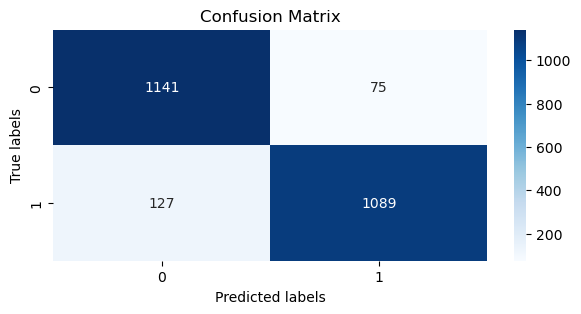

In [58]:
# Logistic Regression
run_model_test(lr_model, X_test_resample, Y_test_resample)

Accuracy is : 0.9177631578947368

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1216
           1       0.97      0.86      0.91      1216

    accuracy                           0.92      2432
   macro avg       0.92      0.92      0.92      2432
weighted avg       0.92      0.92      0.92      2432



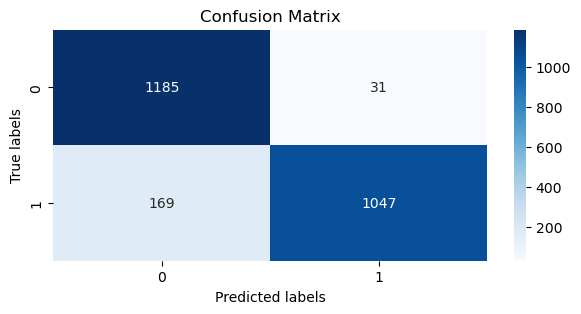

In [59]:
# XGB
run_model_test(xgb_model, X_test_resample, Y_test_resample)

### Testing with Outliers Removed

* Remove outliers
* Perform minority oversampling on both Training and Test dataset
* Train and test the two models.

In [60]:
stroke_df_no_outliers = remove_outliers(stroke_df, ['avg_glucose_level', 'bmi'])


Shape of data before removing outliers : (5109, 18)
Shape of data after remove : (4390, 18)
Total records removed: 719


In [61]:
X2=stroke_df_no_outliers.drop('stroke',axis=1)
Y2=stroke_df_no_outliers['stroke']
Y2.value_counts()

0    4225
1     165
Name: stroke, dtype: int64

In [62]:
X_train2, X_test2, Y_train2, Y_test2=train_test_split(X2,Y2,test_size=0.25,random_state=0, stratify=Y2)

# Training Set
for i in range(0,2):
    print(i, ":", Y_train2[Y_train2==i].size)

# Testing Set
for i in range(0,2):
    print(i, ":", Y_test2[Y_test2==i].size)

0 : 3168
1 : 124
0 : 1057
1 : 41


In [63]:
sm = SMOTE(random_state=0)
X_train_resample2, Y_train_resample2 = sm.fit_resample(X_train2, Y_train2)
X_test_resample2, Y_test_resample2 = sm.fit_resample(X_test2, Y_test2)

for i in range(0,2):
    print(i, ":", Y_train_resample2[Y_train_resample2==i].size)

for i in range(0,2):
    print(i, ":", Y_test_resample2[Y_test_resample2==i].size)

0 : 3168
1 : 3168
0 : 1057
1 : 1057


Accuracy is : 0.9082308420056765

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1057
           1       0.95      0.86      0.90      1057

    accuracy                           0.91      2114
   macro avg       0.91      0.91      0.91      2114
weighted avg       0.91      0.91      0.91      2114



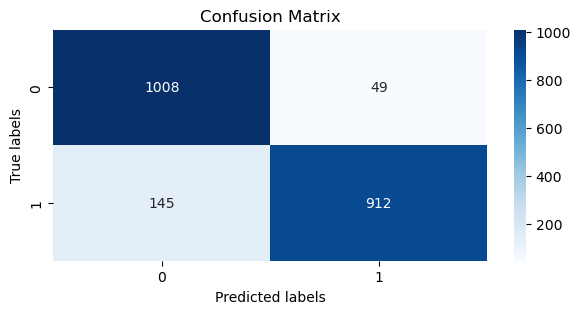

In [64]:
# Retrain LR model with outliers removed
lr_model2 = train_LR_model(X_train_resample2,Y_train_resample2)

# Test model
run_model_test(lr_model2, X_test_resample2, Y_test_resample2)

Accuracy is : 0.9016083254493851

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1057
           1       0.98      0.82      0.89      1057

    accuracy                           0.90      2114
   macro avg       0.91      0.90      0.90      2114
weighted avg       0.91      0.90      0.90      2114



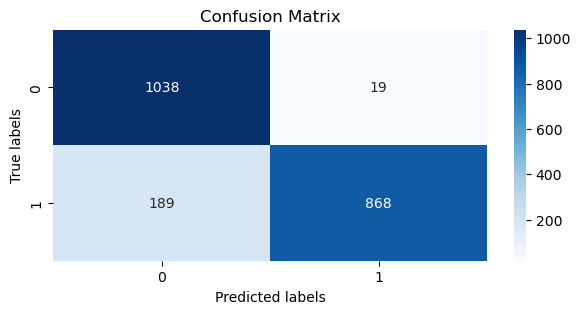

In [65]:
# Retrain XGB model with outliers removed
xgb_model2 = train_XGB_model(X_train_resample2, Y_train_resample2)

# Test model
run_model_test(xgb_model2, X_test_resample2, Y_test_resample2)

# Conclusion

Please note that all models being trained are using default parameters.

In terms of predicting True Positive cases (stroke cases), Logistic Regression performs slightly better than XGB but XGB performs better in terms of True Negative cases (not stroke cases).

Recall and F1-score of Logistic Regression model are also higher as compare to XGB even though XGB has overall better accuracy than Logistic Regression.

    - Recall (Sensibility) is the percentage of predicted positive out of all the positive cases.
    - Precision is the percentage of truly positive out of the positives predicted.
    - F1-Score is the harmonic mean of precision and recall.

As our objective of this case study is to identify who are the patients at higher risk of developing stroke (postive cases), the model which has an better accuracy in predicting True Positive better would be **Logistic Regression** for this case study, which of cos not to compromise the accuracy in predicting correctly for those not in risk of stroke.

<a href = "FinalResults.pdf"> Test Results </a>

### Notes

To improve performance, the models can be tested with different hyperparameters to see which are the best fit.

Other suitable ML models like Random Forest or SVM etc can be explored using the dataset.
    
Obtained more data (if possible) to train the model further to improve the model performance.
For example, if we assume the dataset (that was been oversample before the train and test split) was an actual balanced raw dataset obtained, based on the result tested, XGB performs much better than Logistic Regression)

For the test with the outliers being removed (around 700 out of 5110 records), both models have their performance slightly lowered, possibly due to information loss of other features which are critical to the target variable, and also the sample size is much reduced. The dataset is already not huge to begin with.

Instead, we can consider replacing the outliers with other values, such as the mean, median, or mode of the data, or the nearest neighbor or cluster centroid of the data, which can preserve the sample size and maintain the consistency of the data.

The decision to remove, replace or to remain the outliers as it is, is much dependent on the dataset and use case of the data.